In [ ]:
def load_data(path):
    with open(path, 'r') as f:
        result = json.load(f)

    f.close()
    return result

def save_data(data, path):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)
    f.close()

In [ ]:
import json

total_skill_jds = load_data('data/train/total_skill_jds.json')

# Filter Data

In [59]:
import json

removed_skill = load_data('data/removed_skill.json')

In [60]:
for idx, skills in enumerate(total_skill_jds):
    total_skill_jds[idx] = [s for s in skills if s not in removed_skill]

In [64]:
# save to train
import json

json_path = 'data/train/total_skill_jds_removed_minout.json'
save_data(total_skill_jds, json_path)

In [85]:
import json

json_path = 'data/train/total_skill_jds_removed_minout.json'

total_skill_jds = load_data(json_path)

# Augmentation Data

In [77]:
# valid data
valid_data_path = 'data/valid/skills_valid.json'

def load_valid_data(filename):

    with open(filename, 'r') as f:
        valid_data = json.load(f)

    f.close()

    # total valid skill
    total_valid_skill = 0
    for skill in valid_data.keys():
        total_valid_skill += len(valid_data[skill])

    print(f'Total valid skill: {total_valid_skill}')

    return valid_data

valid_data = load_valid_data(valid_data_path)

Total valid skill: 47400


In [78]:
import random
import numpy as np

def shuffle_data(skills):
    # Make a copy of the input list to avoid modifying the original list
    shuffled_skills = skills.copy()
    
    # Shuffle the copy of the list in place
    random.shuffle(shuffled_skills)
    
    return shuffled_skills

def cutout_data(skills, mask_size=5):

    cutout_skills = skills.copy()
    
    mask_size = min(mask_size, len(cutout_skills))
    
    cutout_index = random.sample(range(len(skills)), mask_size)
    
    for idx in cutout_index:
        cutout_skills[idx] = ''
        

    cutout_skills = [x for x in cutout_skills if x != '']
    
    return cutout_skills


## Type 1 Augmentation

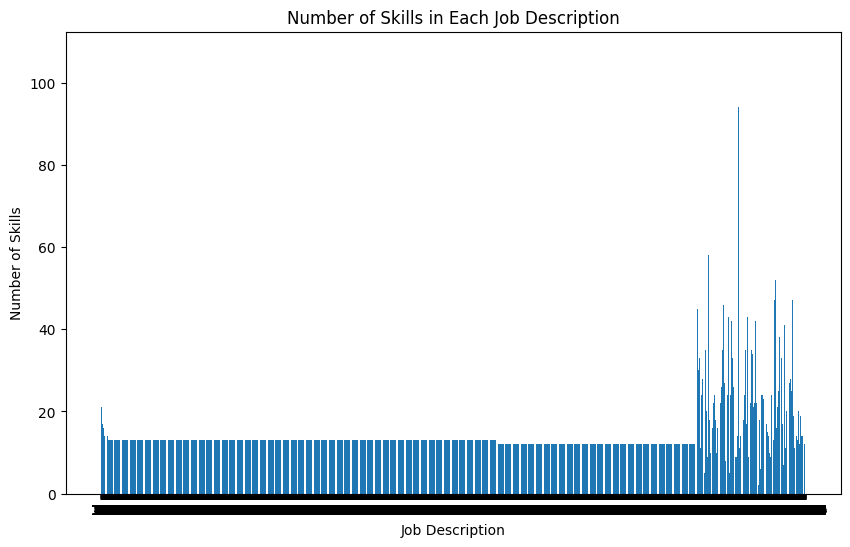

In [7]:
# visualize len of skills of each jd in total_skill_jds
import matplotlib.pyplot as plt

len_skills = [len(skills) for skills in total_skill_jds]

# Create a bar chart to visualize the number of skills for each JD
plt.figure(figsize=(10, 6))  # Set the figure size (adjust as needed)
plt.bar(range(len(total_skill_jds)), len_skills, tick_label=range(1, len(total_skill_jds) + 1))
plt.xlabel('Job Description')
plt.ylabel('Number of Skills')
plt.title('Number of Skills in Each Job Description')
plt.show()

In [ ]:
# count len of skills of each jd in total_skill_jds

from collections import Counter

def count_skills(total_skill_jds):
    len_skills = [len(skills) for skills in total_skill_jds]

    count_skills = Counter(len_skills)
    return count_skills

In [ ]:
import math

def cut_skills(skills, length=13):
    new_cuted = []
    if len(skills) > length:
        num_cut = math.ceil(len(skills) / length)
        for i in range(num_cut):
            if i == num_cut - 1:
                new_cuted.append(skills[i * length:])
            else:
                new_cuted.append(skills[i * length: (i + 1) * length])
    else:
        new_cuted.append(skills)
        
    return new_cuted

In [ ]:
def cut_skills_for_all(total_skill_jds, length=13):
    new_total_skill_jds = []
    for skills in total_skill_jds:
        new_total_skill_jds += cut_skills(skills, length)
    
    return new_total_skill_jds

In [82]:
total_skill_jds_fixed_size = cut_skills_for_all(total_skill_jds, 15)

In [88]:
# save to train
json_path = 'data/train/total_skill_jds_fixed_size.json'
save_data(total_skill_jds_fixed_size, json_path)

### Augmentation data

In [89]:
total_skill_jds = load_data('data/train/total_skill_jds_fixed_size.json')

In [90]:
def shuffle_all_skill(skills_jds):
    new_data = []
    for skills in skills_jds:
        new_data.append(shuffle_data(skills))
    
    return new_data

In [91]:
data_augmenation = shuffle_all_skill(total_skill_jds)
total_skill_jds += data_augmenation
len(total_skill_jds)

63160

In [92]:
save_data(total_skill_jds, 'data/train/total_skill_jds_fixed_size_augmentation.json')

## Type 2 Augmentation

### Pre Augmentation

In [43]:
def get_frequency_skill(skills_jds):

    frequency_skills = {}
    for skills in skills_jds:
        for skill in skills:
            if skill not in list(frequency_skills.keys()):
                frequency_skills[skill] = 1
            else:
                frequency_skills[skill] += 1

     # Sort the dictionary by frequency in descending order
    sorted_frequency_skills = dict(sorted(frequency_skills.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_frequency_skills

In [44]:
def find_frequency_skill_around(skill, k=-1, size=3, total_skill_jds=total_skill_jds):
    frequency = {}
    for skills in total_skill_jds:
        
        if skill in skills:
            # get sublist with size is from center to horizon
            index = skills.index(skill)
            sublist = list()
            start=int
            end=int
            if len(skills) <= size * 2 + 1:
                sublist = skills.copy()
            else:
                start = index - size
                end = index + size
                if start < 0:
                    start = 0
                if end > len(skills):
                    end=len(skills)

                sublist = skills[start:end].copy()

            for s in sublist:
                if s in frequency:
                    frequency[s] += 1
                else:
                    frequency[s] = 1
            
        else:
            continue

    # sort frequency
    frequency = {k: v for k, v in sorted(frequency.items(), key=lambda item: item[1], reverse=True)}

    if k == -1:
        return {i: frequency[i] for i in list(frequency)[1:]}
    else:
        # return top k skill and remove top 1 (skill a)
        return {i: frequency[i] for i in list(frequency)[1:k+1]}

In [45]:
frequency = get_frequency_skill(total_skill_jds)

In [46]:
import math

def group_skills_relevant(skills, size=20):

    skills_copy = skills.copy()
    # short by frequency of skill
    # skills_copy = sorted(skills_copy, key=lambda x: frequency[x], reverse=True) # is it good

    num_group = math.ceil(len(skills) / size)
    len_last_group = round(math.modf(len(skills) / size)[0] * size)

    sorted_skill = [] # list of list (group)

    for idx in range(num_group):

        if idx != num_group - 1:
            len_group = size
        else:
            sorted_skill.append(skills_copy)

            return sorted_skill

        start_gr = 0
        stake = skills_copy[start_gr]
        
        skills_copy.pop(start_gr)
        
        group_skill = []
        group_skill.append(stake)

        #region block code 1: find skill in list in around skill
        around_skill = find_frequency_skill_around(stake, len_group)
        for i, skill in enumerate(skills_copy):

            # region block code 2: end find relevant skill
            if len(group_skill) == len_group:
                # sorted_skill.append(group_skill)
                break
            # endregion

            if skill in around_skill:
                group_skill.append(skill)
                skills_copy.pop(i)
        
        group_skill[1:] = sorted(group_skill[1:], key=lambda x: around_skill[x], reverse=True)
        #endregion

        if len(group_skill) < len_group and len(group_skill) > 1:

            choose_skill = group_skill[1:].copy()
            for _ in range(len(group_skill)-1):
                #region block code 2
                if len(group_skill) == len_group or  len(choose_skill) == 0:
                    break
                #endregion
                
                pivot_skill = max(choose_skill, key=lambda x: around_skill[x])
                choose_skill = [s for s in choose_skill if s != pivot_skill]
                # region block code 1
                around_pivot = find_frequency_skill_around(pivot_skill, len_group-len(group_skill))
                group_pivot = []
                for i, skill in enumerate(skills_copy):
                    
                    # region block code 2
                    if len(group_pivot) == len_group-len(group_skill):
                        break
                    # endregion

                    if skill in around_pivot:
                        group_pivot.append(skill)
                        skills_copy.pop(i)

                group_pivot[1:] = sorted(group_pivot[1:], key=lambda x: around_pivot[x], reverse=True)
                group_skill += group_pivot
                #endregion

        # when loop don't find all element in group
        if len(group_skill) < len_group:
            len_last_group = len_last_group + (len_group - len(group_skill))
            
        sorted_skill.append(group_skill)
            
    return sorted_skill

In [47]:
example = [
        "machine learning",
        "javascript",
        "scalability",
        "selenium",
        "css",
        "nunit",
        "powershell",
        "asp.net extensions for ajax",
        "operations",
        "angular",
        "jquery",
        "c#",
        "ajax",
        "cd",
        "quality assurance",
        "vue.js",
        "react",
        "automated testing",
        "web development",
        "mstest",
        "jenkins",
        "git",
        "databases",
        "sql",
        "html",
        "mvc",
        "unit testing",
        "tdd",
        ".net",
        "static code analysis"
    ]

group_skills_relevant(example)

[['machine learning', 'sql', 'javascript'],
 ['scalability',
  'selenium',
  'css',
  'nunit',
  'powershell',
  'asp.net extensions for ajax',
  'operations',
  'angular',
  'jquery',
  'c#',
  'ajax',
  'cd',
  'quality assurance',
  'vue.js',
  'react',
  'automated testing',
  'web development',
  'mstest',
  'jenkins',
  'git',
  'databases',
  'html',
  'mvc',
  'unit testing',
  'tdd',
  '.net',
  'static code analysis']]

### Function Augmentation

In [11]:
def sort_skills_relevant(total_skills=total_skill_jds):
    
    for idx in range(len(total_skills)):

        # print(idx)
        group_skills = group_skills_relevant(total_skills[idx], 15)

        skills_idx = []
        for group in group_skills:
            skills_idx += group

        total_skills[idx] = skills_idx

    return total_skills

# total_skill_jds = sort_skills_relevant(total_skill_jds)
sort_skills_jds = sort_skills_relevant(total_skill_jds)

In [17]:
# # save to train
# import json

# json_path = 'data/train/total_skill_jds_sorted_relevant.json'
# with open(json_path, 'w') as f:
#     json.dump(total_skill_jds, f, indent=4)

In [12]:
def create_new_data(total_skills, num_samples=2100): # all samples are created = num_samples * 4

    if num_samples > len(total_skills):
        num_samples = len(total_skills) 

    skills_augmentation_collection = []
    # pick random sample in skills jbs
    random_indexs = random.sample(range(len(total_skills)), num_samples)
    for index in random_indexs:

        groups_skills = group_skills_relevant(total_skills[index], 20)

        combine_group_shuffle_1 = []
        # combine_group_shuffle_2 = []
        combine_group_cut_1 = []
        # combine_group_cut_2 = []

        if len(groups_skills) > 2:
            index_cut = random.sample(range(len(groups_skills)), len(groups_skills)-1)
        else:
            index_cut = range(len(groups_skills))

        for idx, group in enumerate(groups_skills):
            # shuffle data
            augment_skill = shuffle_data(group)

            combine_group_shuffle_1 += augment_skill
            # combine_group_shuffle_2 += group

            #cutout
            if idx in index_cut:
                combine_group_cut_1 += augment_skill
                # combine_group_cut_2 += group


        skills_augmentation_collection.append(combine_group_shuffle_1)
        # skills_augmentation_collection.append(combine_group_shuffle_2)
        skills_augmentation_collection.append(combine_group_cut_1)
        # skills_augmentation_collection.append(combine_group_cut_2)

    return skills_augmentation_collection

In [13]:
total_augmentation = create_new_data(total_skill_jds, len(total_skill_jds)) + create_new_data(sort_skills_jds, len(sort_skills_jds))
total_skill_jds += total_augmentation + sort_skills_jds

In [14]:
len(total_skill_jds)

160086

In [15]:
# save to train
import json

json_path = 'data/train/total_skill_augmentation_jds_sorted_relevant_combine_random_and_not.json'
with open(json_path, 'w') as f:
    json.dump(total_skill_jds, f, indent=4)

# End